In [21]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from segment_anything import SamPredictor, sam_model_registry

In [22]:

# Set parameters
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = './Cell'
TEST_PATH = './Cell'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids = next(os.walk(TEST_PATH))[1]
num_test_items = int(0.1 * len(train_ids))

# Slice the train_ids list to get the test IDs
test_ids = train_ids[-num_test_items:]
np.random.seed(10)

import re

#print(len(train_ids))
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float64)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_2 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = os.path.join(TRAIN_PATH, id_)

    img_path = os.path.join(path, 'images', id_ +'_mSLIM'+ '.png')
    if path != "./Cell/Cell/f0_t0_i0_ch0_c15_r44_z0":
        img = imread(img_path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        img = np.expand_dims(img, axis=-1).astype(np.float64)
        
        X_train[n] = img.astype(np.float64)
        
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask = imread(os.path.join(path, 'masks', mask_file))
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            if mask_file.startswith('cell'):
                Y_train_2[n] = np.where(mask[:, :, np.newaxis] > 0, 1, 0)
            else:
                Y_train_1[n] = np.where(mask[:, :, np.newaxis] > 0, 2, 0)

        Y_train[n] = np.maximum(Y_train_1[n], Y_train_2[n])
        


Getting and resizing train images and masks ... 


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


In [23]:
x_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(Y_train).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")  # Load SAM checkpoint
sam.to(device)
predictor = SamPredictor(sam)

In [25]:
# Preprocess images for SAM
def prepare_image(image):

    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    if image.shape[-1] == 1: 
        image = np.repeat(image, 3, axis=-1)  

    return image


In [26]:
def convert_pred_mask(pred_masks):
    output_mask = torch.zeros(pred_masks.shape[1:], dtype=torch.float32, device=pred_masks.device)

    output_mask[pred_masks[1]] = 1.0  
    output_mask[pred_masks[2]] = 2.0  

    output_mask = output_mask.unsqueeze(0)  

    return output_mask

In [27]:
def mean_iou(y_pred, y_true, num_classes=3):
    y_pred = torch.argmax(y_pred, dim=0)  # Get class predictions from multi-channel output
    iou_list = []
    for class_id in range(num_classes):
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        iou_list.append(iou)
    return torch.mean(torch.tensor(iou_list))

In [28]:
criterion = nn.CrossEntropyLoss()

sam.eval()
total_loss = 0.0
total_iou = 0.0

  0%|          | 0/9 [00:00<?, ?it/s]

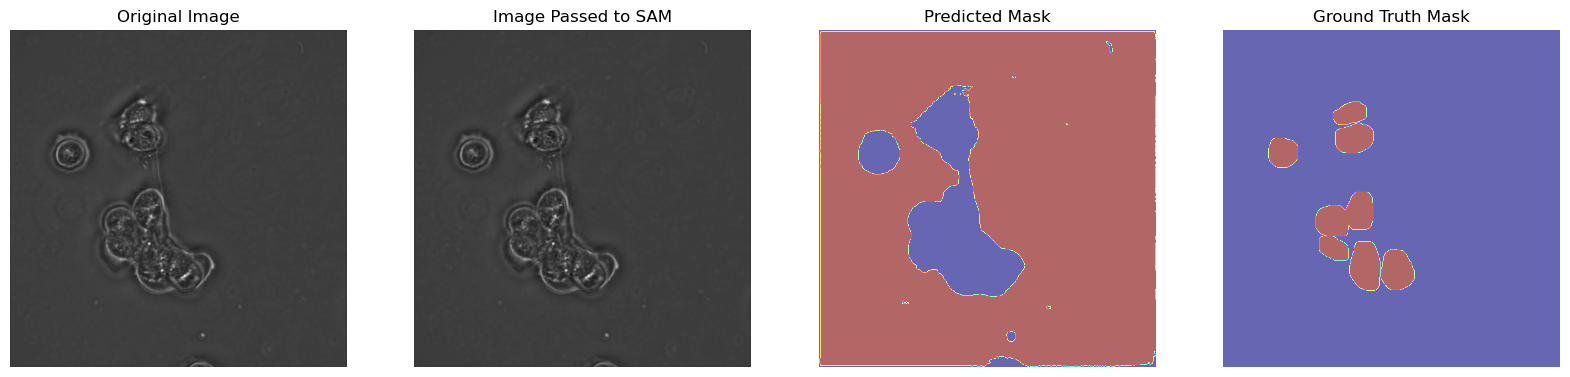

100%|██████████| 9/9 [00:15<00:00,  1.75s/it]

Test Loss: 193.73898145887586, Test IoU: 0.6508161756727431


In [29]:
with torch.no_grad():
    for i, (inputs, true_masks) in enumerate(tqdm(train_loader)):
        inputs = inputs.numpy()[0]  
        inputs_prepped = prepare_image(inputs)

        predictor.set_image(inputs_prepped)
        pred_masks, _, _ = predictor.predict()  

        pred_masks = torch.tensor(pred_masks).to(device)
        pred_masks = convert_pred_mask(pred_masks)
        pred_masks = pred_masks.float()

        true_masks = true_masks.squeeze(1).to(device)
        true_masks = true_masks.squeeze(-1)
        
        loss = criterion(pred_masks, true_masks) 
        iou = mean_iou(pred_masks, true_masks)

        total_loss += loss.item()
        total_iou += iou.item()

        if i == 0:
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 4, 1)
            plt.imshow(inputs[..., 0], cmap='gray')  
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(inputs_prepped[..., 0], cmap='gray') 
            plt.title('Image Passed to SAM')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(pred_masks.squeeze(0).cpu(), cmap='jet', alpha=0.6) 
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(true_masks.squeeze(0).cpu(), cmap='jet', alpha=0.6)  
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.show()


avg_loss = total_loss / len(train_loader)
avg_iou = total_iou / len(train_loader)
print(f"Test Loss: {avg_loss}, Test IoU: {avg_iou}")